In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy

from qiskit import *
from qiskit.visualization import plot_histogram

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa_plus

In [11]:
test_graphs = glob.glob('benchmark_graphs/N10_p50_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N10_p50_graphs/G41.txt
Optimal: ('0011000001', 3)


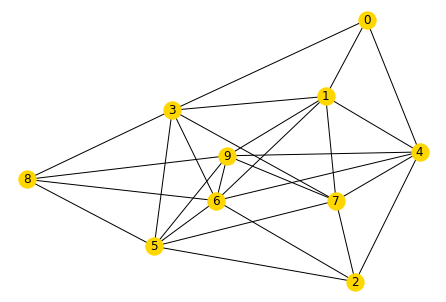

In [12]:
graph = test_graphs[40]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [10]:
def construct_qaoa_plus(P, G, params, barriers=False, measure=False):
    assert (len(params) == 2*P), "Number of parameters should be 2P"
    
    nq = len(G.nodes())
    circ = QuantumCircuit(nq, name='q')
    
    # Initial state
    circ.h(range(nq))
    
    gammas = [param for i, param in enumerate(params) if i % 2 == 0]
    betas  = [param for i, param in enumerate(params) if i % 2 == 1]
    for i in range(P):
        # Phase Separator Unitary
        for edge in G.edges():
            q_i, q_j = edge
            circ.rz(gammas[i] / 2, [q_i, q_j])
            circ.cx(q_i, q_j)
            circ.rz(-1 * gammas[i] / 2, q_j)
            circ.cx(q_i, q_j)
            if barriers:
                circ.barrier()
    
        # Mixing Unitary
        for q_i in range(nq):
            circ.rx(-2 * betas[i], q_i)
    
    if measure:
        circ.measure_all()
    
    return circ

In [11]:
def expectation_value(counts, G, Lambda):
    total_shots = sum(counts.values())
    energy = 0
    for bitstr, count in counts.items():
        temp_energy = hamming_weight(bitstr)
        for edge in G.edges():
            q_i, q_j = edge
            rev_bitstr = list(reversed(bitstr))
            if rev_bitstr[q_i] == '1' and rev_bitstr[q_j] == '1':
                temp_energy += -1 * Lambda
            
        energy += count * temp_energy / total_shots
        
    return energy

In [12]:
P = 1
params = [1 for i in range(2*P)]
qaoa_circ = construct_qaoa_plus(P, G, params, barriers=True)
qaoa_circ.draw(fold=-1)

┌───┐┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ┌────────┐
q_0: ┤ H ├┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RX(-2) ├
     ├───┤└─────────┘  │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ┌─────────┐                       ░ ├────────┤
q_1: ┤ H ├─────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RZ(0.5) ├──■────────────────■───░─┤ RX(-2) ├
     ├───┤┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░              │                │   ░              │                │   ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░ └─────────┘  │                │   ░ ├────────┤
q_2: ┤ H ├┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░──────────────┼────────────────┼───░─┤ RX(-2) ├
     ├───┤└─────────┘└───┘└──────────┘└───┘ ░              │                │   ░              │                │   ░              │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░                                   ░                                   ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░              │                │   ░ ├────────┤
q_3: ┤ H ├──────────────────────────────────░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░───────────────────────────────────░───────────────────────────────────░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░─┤ RX(-2) ├
     ├───┤                                  ░ ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░              │                │   ░ ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░ ┌─────────┐                       ░ ┌─────────┐                       ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░              │                │   ░ ├────────┤
q_4: ┤ H ├──────────────────────────────────░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░──────────────┼────────────────┼───░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░─┤ RZ(0.5) ├──■────────────

In [13]:
def top_strs(counts, G, top=5):
    total_shots = sum(counts.values())
    probs = [(bitstr, counts[bitstr] / total_shots) for bitstr in counts.keys()]
    probs = sorted(probs, key=lambda p: p[1], reverse=True)
    
    for i in range(top):
        print('{} -> {:.4f}%, Is MIS? {}'.format(probs[i][0], probs[i][1] * 100,
                                                 is_indset(probs[i][0], G)))

In [14]:
def f(params, Lambda):
    circ = construct_qaoa_plus(P, G, params, measure=True)
    
    result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
    counts = result.get_counts(circ)
    
    return -1 * expectation_value(counts, G, Lambda)

In [17]:
Lambda = 0.5
P = 3
init_params = [0] * 2 * P
out = scipy.optimize.minimize(f, x0=init_params, args=(Lambda), method='COBYLA')
print(out)

     fun: -3.4512939453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 97
  status: 1
 success: True
       x: array([-0.5066914 ,  0.34942585,  1.17912065,  1.04400981,  1.28602738,
        0.51519881])


Optimal MIS: ('11000110', 4)
11101110 -> 10.1196%, Is MIS? False
11011110 -> 4.1626%, Is MIS? False
11101011 -> 4.0527%, Is MIS? False
01101111 -> 3.9795%, Is MIS? False
11001110 -> 3.9673%, Is MIS? False
11101111 -> 3.5889%, Is MIS? False
01101110 -> 3.5645%, Is MIS? False
11111010 -> 3.2837%, Is MIS? False
Expected energy: 3.45721435546875


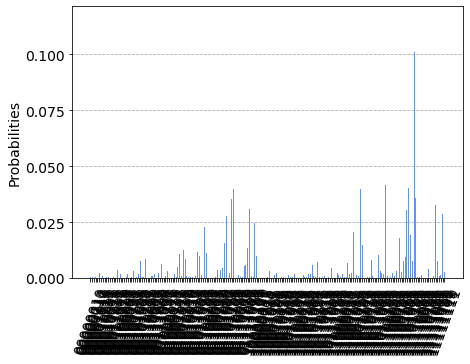

In [18]:
circ = construct_qaoa_plus(P, G, params=out['x'], barriers=False, measure=True)
result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
counts = result.get_counts(circ)
print('Optimal MIS:', brute_force_search(G))
top_strs(counts, G, top=8)
print('Expected energy:', expectation_value(counts, G, Lambda))
plot_histogram(counts, bar_labels=False)

In [7]:
P = 3
Lambda = 0.5
qaoa_plus.solve_mis(P, G, Lambda)

     fun: -2.62005615234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 72
  status: 1
 success: True
       x: array([-0.62199846, -0.35780873, -0.00262411, -0.55451754, -0.09092065,
       -0.20784035])

In [13]:
P = 3
ratios = []
ranks = []
Lambdas = [0.1, 0.5, 0.75, 1, 1.5, 2]
for Lambda in Lambdas:
    out = qaoa_plus.solve_mis(P, G, Lambda)
    exp_val = -1 * out['fun']
    opt_val = brute_force_search(G)[1]
    ranked_probs = qaoa_plus.get_ranked_probs(P, G, out['x'])
    for i, v in enumerate(ranked_probs):
        if v[2]:
            rank = i+1
            prob = v[1]
            break
            
    ratios.append(exp_val/opt_val)
    ranks.append(prob * 100)
    
    print(Lambda, exp_val/opt_val, rank)

0.1 2.28926188151042 220
0.5 0.8227335611979166 1
0.75 0.4631144205729167 1
1 0.5032552083333334 1
1.5 0.37628173828125 1
2 -0.16259765625 1


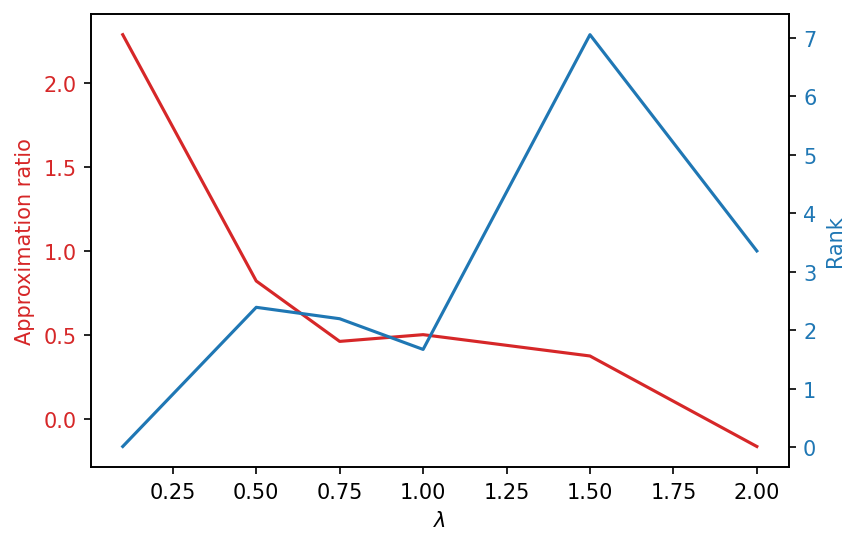

In [14]:
fig, ax1 = plt.subplots(dpi=150)

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Approximation ratio', color=color)
ax1.plot(Lambdas, ratios, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rank', color=color)
ax2.plot(Lambdas, ranks, color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [19]:
np.arange(0.1, 1.6, 0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5])